In [1]:
from pycaret.regression import load_model, predict_model
import pandas as pd
from ax.service.managed_loop import optimize
import numpy as np

In [2]:
# 1. pycaret에서 기존에 구축한 모델 불러오기
model_R = load_model('et_saved_220525_test3')
model_P = load_model('et2_saved_220525_test3')
model_V = load_model('et3_saved_220525_test3')
# Load the test data from CSV into a DataFrame
test_df = pd.read_csv('Test_data_ML-R9_220516_test3_MW.csv', encoding='cp949')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [3]:
# 2. 모델이 잘 불러왔는지, 작동하는지 테스트 (test 데이터 csv를 이용)
# test_results = predict_model(model_R, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_P, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_V, data=test_df)
# print(test_results.head())

In [12]:
# 3. Bayesian optimization을 이용하여, objective function 최대화
# input data 불러오기
input_df = pd.read_csv('Bays_data_initial 10_251007.csv', encoding='cp949')

# base와 columns 정의
base = input_df.iloc[0].copy()
columns = input_df.columns

def pycaret_predict(params):
    # 파라미터 매핑
    param_map = {
        "Feed_rate_SLPM": "Feed rate (SLPM)",
        "Rinse_rate_SLPM": "Rinse rate (SLPM)",
        "Pad_bar": "Pad (bar)",
        "Pde_bar": "Pde (bar)"
    }
    updated_base = base.copy()
    for k, v in params.items():
        updated_base[param_map[k]] = v
    input_row_updated = {col: updated_base[col] for col in columns}
    input_df_pred = pd.DataFrame([input_row_updated])

    # 모델 예측
    pred_R = predict_model(model_R, data=input_df_pred)
    pred_P = predict_model(model_P, data=input_df_pred)
    pred_V = predict_model(model_V, data=input_df_pred)

    # obj 계산 (이전 논문 참조)
    Feed_CO = 0.2 * input_df_pred['Feed rate (SLPM)'] * 60 / (10**3 * 0.082057 * 273.15)
    Product_CO = Feed_CO * pred_R['prediction_label'] / 100
    k_comp = 1.4 * (0.517 + 0.253) + 1.28 * 0.23
    k_vc = 1.4
    mu = 0.75
    Feed_Compressor = 2.78e-4 * k_comp / (k_comp - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_comp - 1) / k_comp - 1)
    Rinse_Compressor = 2.78e-4 * k_vc / (k_vc - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_vc - 1) / k_vc - 1)
    Vacuum_Pump = 2.78e-4 * k_vc / (k_vc - 1) * 100 * mu / mu / (1 / input_df_pred['Pde (bar)']) ** ((k_vc - 1) / k_vc - 1)
    Electricity = Feed_Compressor + Rinse_Compressor * (input_df_pred['Rinse rate (SLPM)'] / input_df_pred['Feed rate (SLPM)']) + Vacuum_Pump * (pred_V['prediction_label'] / input_df_pred['Feed rate (SLPM)'])

    CO_Low = (pred_P['prediction_label'] / 100) * (2411 / 11000) * 0.528
    CO_High = 15.49008 * np.exp(0.75093 * (pred_P['prediction_label'] - 98))
    CO_Price = np.maximum(CO_Low, CO_High)

    Fee_gas = (20 / 100) * (2411 / 11000) * 0.528
    Elec_price = 0.1
    Propit = CO_Price * Product_CO * 22.4
    Cost = input_df_pred['Feed rate (SLPM)'] * (60 / 10**3) * Fee_gas
    Opex = (60 / 10**3) * input_df_pred['Feed rate (SLPM)'] * Electricity * Elec_price

    obj = Propit - Cost - Opex
    # 예측값과 obj를 반환하도록 수정
    return {
        'obj': obj.iloc[0],
        'pred_R': pred_R['prediction_label'].iloc[0],
        'pred_P': pred_P['prediction_label'].iloc[0],
        'pred_V': pred_V['prediction_label'].iloc[0]
    }

# 결과 저장용 리스트
history = []

def evaluation_function(params):
    result = pycaret_predict(params)
    row = {
        **params,
        'pred_R': result['pred_R'],
        'pred_P': result['pred_P'],
        'pred_V': result['pred_V'],
        'obj': result['obj']
    }
    history.append(row)
    return result['obj']

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "Feed_rate_SLPM", "type": "range", "bounds": [2, 8], "value_type": "float"},
        {"name": "Rinse_rate_SLPM", "type": "range", "bounds": [0.8, 2.1], "value_type": "float"},
        {"name": "Pad_bar", "type": "range", "bounds": [2.5, 6.4], "value_type": "float"},
        {"name": "Pde_bar", "type": "range", "bounds": [0.05, 0.15], "value_type": "float"},
    ],
    evaluation_function=evaluation_function,
    minimize=False,
    total_trials=50,
)

# 이력 데이터프레임 생성
history_df = pd.DataFrame(history)
print(history_df.head())

print("Best parameters found:", best_parameters)
print("Best objective value:", values)

[INFO 10-08 16:22:32] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 10-08 16:22:32] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 8 trials, BoTorch for subsequent trials]). Iterations after 8 will take longer to generate due to model-fitting.
[INFO 10-08 16:22:32] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 10-08 16:22:32] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-08 16:22:32] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-08 16:22:33] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-08 16:22:33] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-08 16:22:34] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-08 16:22:34] ax.service.managed_loop

   Feed_rate_SLPM  Rinse_rate_SLPM   Pad_bar   Pde_bar     pred_R     pred_P  \
0        2.476221         1.687661  3.730396  0.071266  91.319383  91.964420   
1        6.570226         0.916376  6.143172  0.108184  82.000002  85.742983   
2        5.972147         1.858579  2.613392  0.087030  43.662716  99.991658   
3        4.996054         1.329764  5.312109  0.148548  80.921102  87.688568   
4        3.941942         1.972663  5.764086  0.128636  85.055500  96.259477   

     pred_V       obj  
0  1.525089 -0.047873  
1  1.740872 -0.194626  
2  1.832350  2.102635  
3  1.852506 -0.128335  
4  2.226377  0.027242  
Best parameters found: {'Feed_rate_SLPM': 8.0, 'Rinse_rate_SLPM': 2.058706761045238, 'Pad_bar': 6.4, 'Pde_bar': 0.05}
Best objective value: ({'objective': 3.9345050428560233}, {'objective': {'objective': 0.00023768203035307408}})


In [13]:
history_df

,Feed_rate_SLPM,Rinse_rate_SLPM,Pad_bar,Pde_bar,pred_R,pred_P,pred_V,obj
0,2.476221,1.687661,3.730396,0.071266,91.319383,91.964420,1.525089,-0.047873
1,6.570226,0.916376,6.143172,0.108184,82.000002,85.742983,1.740872,-0.194626
2,5.972147,1.858579,2.613392,0.087030,43.662716,99.991658,1.832350,2.102635
3,4.996054,1.329764,5.312109,0.148548,80.921102,87.688568,1.852506,-0.128335
4,3.941942,1.972663,5.764086,0.128636,85.055500,96.259477,2.226377,0.027242
5,5.104528,1.281379,4.109459,0.092111,81.441444,90.478269,1.588917,-0.086159
6,7.623606,1.573557,4.479564,0.113265,59.315400,96.874706,2.008581,0.212047
7,3.344572,0.964781,3.445915,0.051353,92.807854,83.039285,1.205205,-0.046307
8,7.630339,2.100000,2.500000,0.104471,28.082377,99.996960,1.789203,1.716240
9,3.797718,2.100000,2.500000,0.078028,62.133836,99.943408,1.902378,1.843443


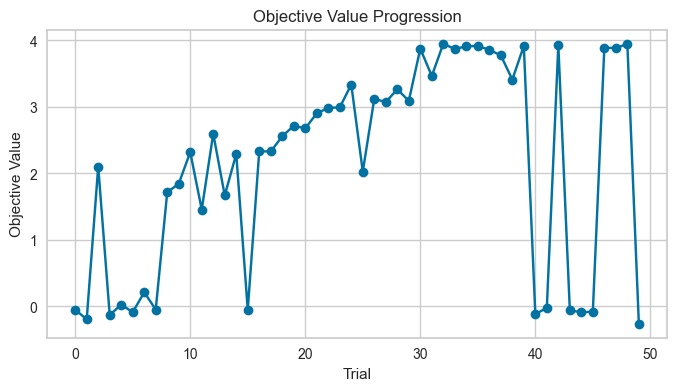

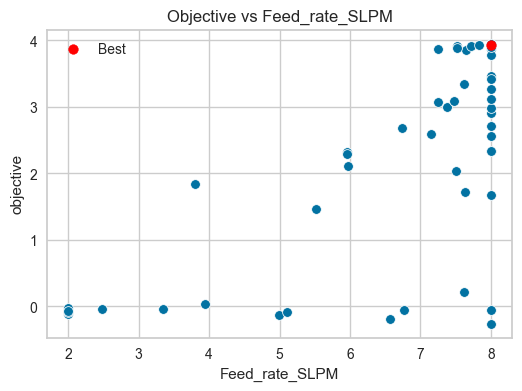

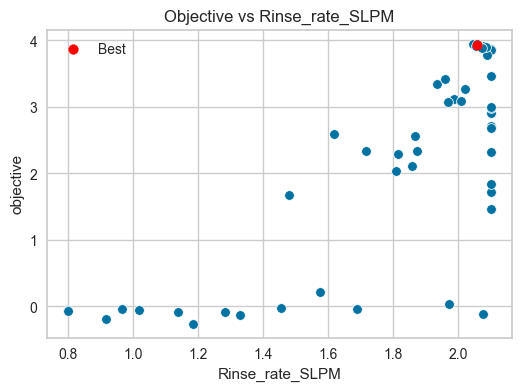

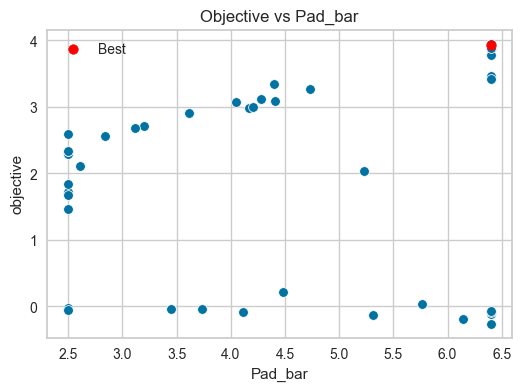

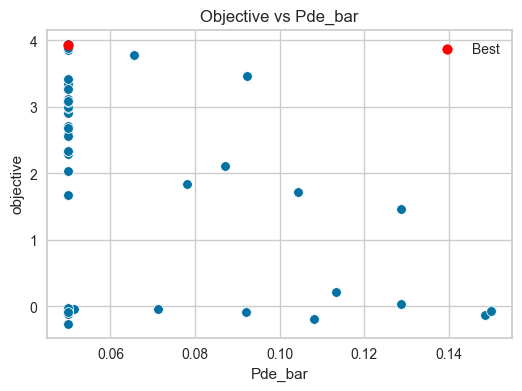

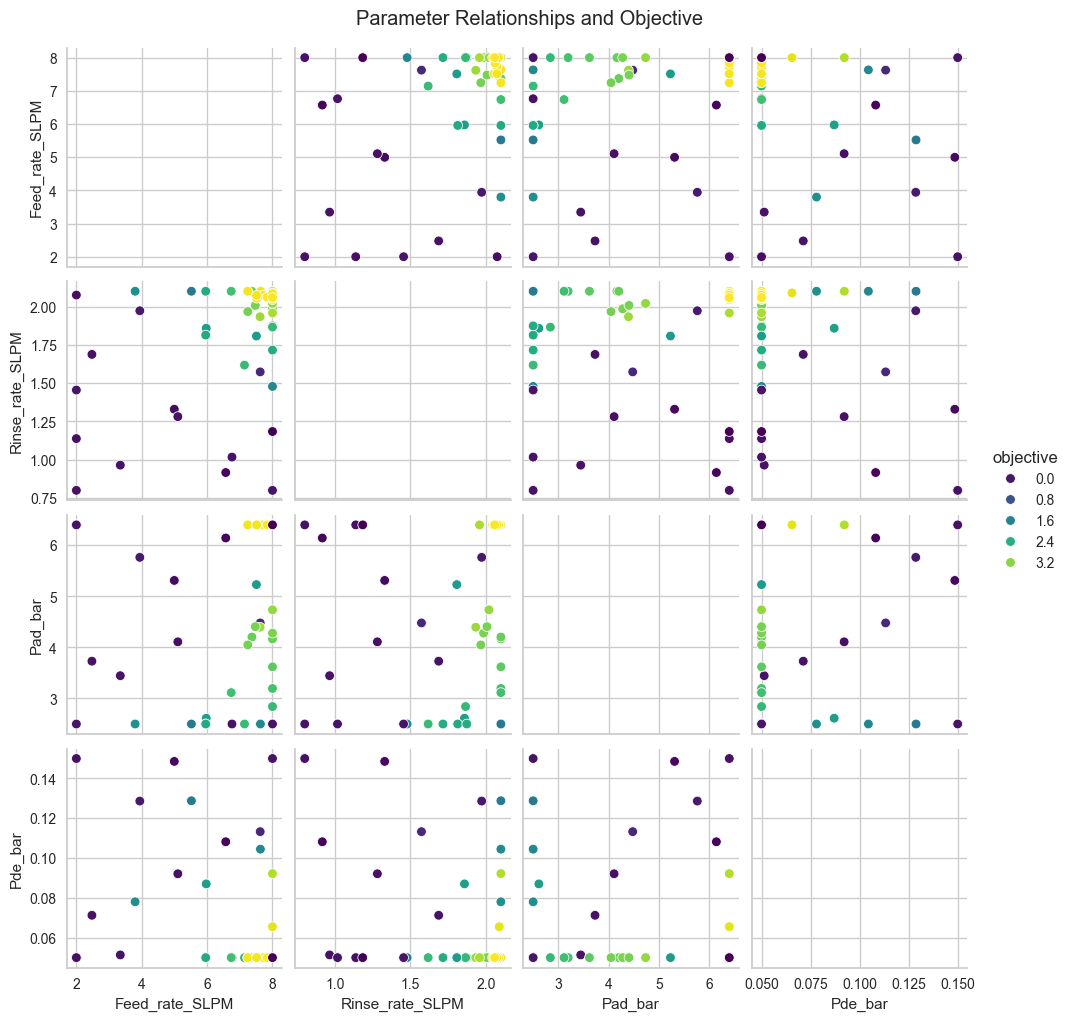

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Objective 값의 변화 추이
objective_values = [trial.objective_mean for trial in experiment.trials.values()]
plt.figure(figsize=(8,4))
plt.plot(objective_values, marker='o')
plt.xlabel('Trial')
plt.ylabel('Objective Value')
plt.title('Objective Value Progression')
plt.show()

# 2. 파라미터별 Objective 값 분포
results = []
for trial in experiment.trials.values():
    params = trial.arm.parameters
    obj = trial.objective_mean
    params['objective'] = obj
    results.append(params)
results_df = pd.DataFrame(results)

param_names = ['Feed_rate_SLPM', 'Rinse_rate_SLPM', 'Pad_bar', 'Pde_bar']
for param in param_names:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=results_df, x=param, y='objective')
    plt.scatter(best_parameters[param], values[0]['objective'], color='red', label='Best', zorder=5)
    plt.title(f'Objective vs {param}')
    plt.legend()
    plt.show()

# 3. Pairplot
sns.pairplot(results_df, vars=param_names, hue='objective', palette='viridis')
plt.suptitle('Parameter Relationships and Objective', y=1.02)
plt.show()